# Building Fusion model

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import TensorBoard
from tensorboard.plugins.hparams import api as hp
import datetime

import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
import keras

In [2]:
# build_rgb_stream
class Build_Fusion_Model:
    # build_ssd
    def build_ssd_stream(self):
        base_model = MobileNetV2(input_shape=(320, 320, 3), include_top=False, weights='imagenet')
        # Freeze the base model layers
        for layer in base_model.layers:
            layer.trainable = False
        
        x = base_model.output
        x = GlobalAveragePooling2D()(x)
        x = Dense(1024, activation='relu')(x)
        x = Dense(256, activation='relu')(x)
        x = layers.Dropout(0.5)(x)

        self.model = Model(inputs=base_model.input, outputs=x)
        # print(self.model.summary())
        return self.model
    
    # build_pose_stream
    def build_pose_stream(self,input_shape=(20, 17*2)):
        self.model = models.Sequential()

        # Add LSTM layers for processing pose keypoints over time
        self.model.add(layers.LSTM(64, input_shape=input_shape, return_sequences=True))
        self.model.add(layers.LSTM(128, return_sequences=True))
        self.model.add(layers.LSTM(256, return_sequences=True))

        self.model.add(layers.Dense(256, activation='relu'))
        self.model.add(layers.Dropout(0.5))

        return self.model

# build_fusion_model
    def build_fusion_model(self,ssd_stream, pose_stream, num_classes):
        # Combine the two streams
        self.ssd_stream_flattened = layers.Flatten()(ssd_stream.output)
        self.pose_stream_flattened = layers.Flatten()(pose_stream.output)
        combined_input = layers.concatenate([self.pose_stream_flattened, self.ssd_stream_flattened])

        # Add fully connected layers for fusion
        self.fusion_dense = layers.Dense(512, activation='relu')(combined_input) # replace with (combined_input)
        self.fusion_dense = layers.Dropout(0.5)(self.fusion_dense)

        self.fusion_output = layers.Dense(num_classes, activation='sigmoid')(self.fusion_dense)

        # Create the final model
        self.fusion_model = models.Model(inputs=[pose_stream.input, ssd_stream.input], outputs=self.fusion_output)

        return self.fusion_model

In [3]:
# Set the number of classes for your action recognition task
num_classes = 1
build_model = Build_Fusion_Model()
# Build the RGB stream
ssd_stream = build_model.build_ssd_stream()

# Build the Pose stream
pose_stream = build_model.build_pose_stream(input_shape=(10, 34))

# Build the Fusion model
fusion_model = build_model.build_fusion_model(ssd_stream, pose_stream, num_classes)


# Define hyperparameters
hp_epochs = hp.HParam('epochs', hp.IntInterval(10, 50))
hp_learning_rate = hp.HParam('learning_rate', hp.RealInterval(1e-4, 1e-2))

# Create a summary file for TensorBoard
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Create a callback for hyperparameter logging
hparams_callback = hp.KerasCallback(log_dir, hparams={hp_epochs: 20, hp_learning_rate: 1e-3})


#Checkpoints
checkpoint_filepath = 'models/ckpt/{epoch:02d}-{val_loss:.2f}.keras5'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    # save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

# Early stoping
early_stoping = keras.callbacks.EarlyStopping()

# Compile the model with an appropriate optimizer, loss, and metrics
optimizer = keras.optimizers.Adam()
fusion_model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Display the model summary
# fusion_model.summary()


In [4]:
# tf.keras.utils.plot_model(fusion_model, show_shapes=True, show_layer_names=True)

In [5]:
fusion_model.input_shape

[(None, 10, 34), (None, 320, 320, 3)]

In [6]:
fusion_model.output_shape

(None, 1)

# Inference

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from video_processor import VideoProcessor

In [8]:
df = pd.read_csv('../datasets/KTH/dataset.csv')
df.head()

,clip_path,label
0,../datasets/KTH/boxing\person01_boxing_d1_unco...,boxing
1,../datasets/KTH/boxing\person01_boxing_d2_unco...,boxing
2,../datasets/KTH/boxing\person01_boxing_d3_unco...,boxing
3,../datasets/KTH/boxing\person01_boxing_d4_unco...,boxing
4,../datasets/KTH/boxing\person02_boxing_d1_unco...,boxing


In [9]:
df['label'].unique()

array(['boxing', 'handclapping', 'handwaving', 'jogging', 'running', 'walking'], dtype=object)

In [10]:
def three_class(x):
    if x not in ['golf', 'kick_ball', 'pushup', 'shoot_ball',  
             'shoot_bow', 'shoot_gun', 'swing_baseball', 
             'thow', 'BoxingPunchingBag', 'boxing', 'punch', 
             'kick', 'point', 'handwaving', 'wave']:
        return 0
    else:
        return 1

In [11]:
df['label'] = df['label'].apply(three_class)

In [12]:
classwise_df = []

for i in df['label'].unique():
    classwise_df.append(df[df['label']==i].reset_index())

# Inference on Dataset

In [13]:
from ultralytics import YOLO
import cv2

In [14]:
model = YOLO('models/yolov8m-pose.pt') 

In [15]:
total_df = pd.DataFrame()
for df in classwise_df:
    total_df = pd.concat([total_df, df])


In [16]:
for i, d in total_df.sample(5).groupby('label'):
    print(d)

     index                                          clip_path  label
366    566  ../datasets/KTH/walking\person17_walking_d4_un...      0
80     180  ../datasets/KTH/handclapping\person21_handclap...      0
45     145  ../datasets/KTH/handclapping\person12_handclap...      0
187    387  ../datasets/KTH/jogging\person23_jogging_d1_un...      0
     index                                          clip_path  label
178    277  ../datasets/KTH/handwaving\person20_handwaving...      1


# Training

In [17]:
import cv2
import numpy as np
import pandas as pd
from random import shuffle
import os

def data_generator(total_df, batch_size=1, shuffle_data=True, resize=320):
    """
    Yields the next training batch.
    Suppose `total_df` is a pandas DataFrame with columns 'clip_path' and 'label'.
    """
    num_samples = len(total_df)
    samples = list(total_df.iterrows())  # Convert DataFrame to a list of (index, row) tuples

    while True:  # Loop forever so the generator never terminates
        if shuffle_data:
            shuffle(samples)

        # Get index to start each batch: [0, batch_size, 2*batch_size, ..., max multiple of batch_size <= num_samples]
        for offset in range(0, num_samples, batch_size):
            # Get the samples you'll use in this batch
            batch_samples = samples[offset:offset+batch_size]

            # Initialise pose_buffer and labels arrays for this batch
            pose_buffer = []
            rbg_buffer = []
            labels = []

            # For each example
            for _, batch_sample in batch_samples:
                # Load video (X) and label (y)
                vid_path = batch_sample['clip_path']
                label = batch_sample['label']
                cap = cv2.VideoCapture(vid_path)
                frame_buffer = []
                while True:
                    ret, frame = cap.read()
                    if not ret:
                        cap.release()
                        break

                    frame = cv2.resize(frame, (resize, resize))
                    if len(frame_buffer) < 10:
                        frame_buffer.append(frame)
                    elif len(frame_buffer) == 10:
                        batch = vp.process_video(frame_buffer)
                        batch = np.array(batch)[:, 0, :].reshape(-1, 10, 34)
                        pose_buffer.append(batch[0])
                        rbg_buffer.append(frame)
                        frame_buffer = []
                        labels.append(label)
                    else:
                        frame_buffer = []

                # labels.extend([label] * len(pose_buffer))  # Extend the labels list for this video's frames

            # Make sure they're numpy arrays (as opposed to lists)
            pose_buffer = np.array(pose_buffer)
            rbg_buffer = np.array(rbg_buffer)
            labels = np.array(labels)
            # print(len(labels))


            # res = [pose_buffer, rbg_buffer], labels
            # print(res[0][0].shape, res[0][1].shape, res[1].shape)

            # The generator-y part: yield the next training batch
            yield [pose_buffer, rbg_buffer], labels  # ([(None, 10, 34), (None, 640, 640, 3)], (None,1))


In [18]:
vp = VideoProcessor(model, max_frames=100, img_sz=320, show_stream=False)

In [19]:
from sklearn.model_selection import train_test_split

# total_df = total_df[:10]
train_df, test_df = train_test_split(total_df, test_size=0.2, random_state=42)
train_df, val_df  = train_test_split(total_df, test_size=0.25, random_state=42)


In [20]:
from keras.models import load_model
fusion_model = load_model("models/ckpt/01-0.51.keras5")

In [30]:
batch_size = 1
num_epochs = 27
train_generator = data_generator(train_df, batch_size=batch_size)
val_generator = data_generator(val_df, batch_size=1)
steps_per_epoch = len(total_df) // batch_size
# steps_per_epoch = 2
# Now, you can use this generator to train your model
history = fusion_model.fit(train_generator, steps_per_epoch=steps_per_epoch//2, epochs=num_epochs,
                           validation_data = val_generator, validation_steps=15,
                           callbacks=[model_checkpoint_callback])

Epoch 1/27
299/299 [==============================] - ETA: 0s - loss: 0.4885 - accuracy: 0.7219

INFO:tensorflow:Assets written to: models/ckpt\01-0.49.keras5\assets


INFO:tensorflow:Assets written to: models/ckpt\01-0.49.keras5\assets


299/299 [==============================] - 923s 3s/step - loss: 0.4885 - accuracy: 0.7219 - val_loss: 0.4854 - val_accuracy: 0.8370
Epoch 2/27
299/299 [==============================] - 775s 3s/step - loss: 0.4741 - accuracy: 0.7672 - val_loss: 0.5343 - val_accuracy: 0.5841
Epoch 3/27
299/299 [==============================] - 780s 3s/step - loss: 0.4394 - accuracy: 0.7240 - val_loss: 0.3880 - val_accuracy: 0.8367
Epoch 4/27
299/299 [==============================] - 780s 3s/step - loss: 0.4647 - accuracy: 0.7482 - val_loss: 0.4357 - val_accuracy: 0.7414
Epoch 5/27
299/299 [==============================] - 782s 3s/step - loss: 0.4394 - accuracy: 0.7158 - val_loss: 0.4567 - val_accuracy: 0.7116
Epoch 6/27
299/299 [==============================] - ETA: 0s - loss: 0.4168 - accuracy: 0.7597

INFO:tensorflow:Assets written to: models/ckpt\06-0.44.keras5\assets


INFO:tensorflow:Assets written to: models/ckpt\06-0.44.keras5\assets


299/299 [==============================] - 798s 3s/step - loss: 0.4168 - accuracy: 0.7597 - val_loss: 0.4386 - val_accuracy: 0.8541
Epoch 7/27
299/299 [==============================] - 858s 3s/step - loss: 0.4270 - accuracy: 0.7605 - val_loss: 0.4629 - val_accuracy: 0.8172
Epoch 8/27
299/299 [==============================] - 1145s 4s/step - loss: 0.3844 - accuracy: 0.7852 - val_loss: 0.4773 - val_accuracy: 0.7691
Epoch 9/27
299/299 [==============================] - 1215s 4s/step - loss: 0.5075 - accuracy: 0.7035 - val_loss: 0.8724 - val_accuracy: 0.6146
Epoch 10/27
299/299 [==============================] - 1127s 4s/step - loss: 0.4769 - accuracy: 0.7043 - val_loss: 0.4263 - val_accuracy: 0.7141
Epoch 11/27
299/299 [==============================] - 1062s 4s/step - loss: 0.4092 - accuracy: 0.7850 - val_loss: 0.8155 - val_accuracy: 0.5475
Epoch 12/27
299/299 [==============================] - ETA: 0s - loss: 0.4402 - accuracy: 0.7384

INFO:tensorflow:Assets written to: models/ckpt\12-0.33.keras5\assets


INFO:tensorflow:Assets written to: models/ckpt\12-0.33.keras5\assets


299/299 [==============================] - 1089s 4s/step - loss: 0.4402 - accuracy: 0.7384 - val_loss: 0.3311 - val_accuracy: 0.8780
Epoch 13/27
299/299 [==============================] - 1092s 4s/step - loss: 0.4041 - accuracy: 0.7668 - val_loss: 0.5236 - val_accuracy: 0.7920
Epoch 14/27
299/299 [==============================] - 1153s 4s/step - loss: 0.4081 - accuracy: 0.7597 - val_loss: 0.3178 - val_accuracy: 0.8446
Epoch 15/27
299/299 [==============================] - 1220s 4s/step - loss: 0.3782 - accuracy: 0.7901 - val_loss: 0.4560 - val_accuracy: 0.7880
Epoch 16/27
299/299 [==============================] - 1206s 4s/step - loss: 0.4041 - accuracy: 0.7799 - val_loss: 0.4748 - val_accuracy: 0.7418
Epoch 17/27
299/299 [==============================] - 1097s 4s/step - loss: 0.3885 - accuracy: 0.7779 - val_loss: 0.4666 - val_accuracy: 0.7983
Epoch 18/27
299/299 [==============================] - ETA: 0s - loss: 0.3764 - accuracy: 0.7813

INFO:tensorflow:Assets written to: models/ckpt\18-0.46.keras5\assets


INFO:tensorflow:Assets written to: models/ckpt\18-0.46.keras5\assets


299/299 [==============================] - 1092s 4s/step - loss: 0.3764 - accuracy: 0.7813 - val_loss: 0.4637 - val_accuracy: 0.8790
Epoch 19/27
299/299 [==============================] - 1063s 4s/step - loss: 0.3691 - accuracy: 0.7707 - val_loss: 0.3277 - val_accuracy: 0.7952
Epoch 20/27
299/299 [==============================] - ETA: 0s - loss: 0.3979 - accuracy: 0.7825

INFO:tensorflow:Assets written to: models/ckpt\20-0.35.keras5\assets


INFO:tensorflow:Assets written to: models/ckpt\20-0.35.keras5\assets


299/299 [==============================] - 1078s 4s/step - loss: 0.3979 - accuracy: 0.7825 - val_loss: 0.3466 - val_accuracy: 0.8870
Epoch 21/27
299/299 [==============================] - 1100s 4s/step - loss: 0.3727 - accuracy: 0.7964 - val_loss: 0.3786 - val_accuracy: 0.8301
Epoch 22/27
299/299 [==============================] - ETA: 0s - loss: 0.3763 - accuracy: 0.7922

INFO:tensorflow:Assets written to: models/ckpt\22-0.39.keras5\assets


INFO:tensorflow:Assets written to: models/ckpt\22-0.39.keras5\assets


299/299 [==============================] - 1099s 4s/step - loss: 0.3763 - accuracy: 0.7922 - val_loss: 0.3909 - val_accuracy: 0.9680
Epoch 23/27
299/299 [==============================] - 1090s 4s/step - loss: 0.3715 - accuracy: 0.7955 - val_loss: 0.3479 - val_accuracy: 0.8277
Epoch 24/27
299/299 [==============================] - 1071s 4s/step - loss: 0.3524 - accuracy: 0.7958 - val_loss: 0.3488 - val_accuracy: 0.8424
Epoch 25/27
299/299 [==============================] - 1041s 3s/step - loss: 0.3865 - accuracy: 0.7776 - val_loss: 0.4380 - val_accuracy: 0.7170
Epoch 26/27
299/299 [==============================] - 1035s 3s/step - loss: 0.3712 - accuracy: 0.7843 - val_loss: 0.4876 - val_accuracy: 0.6841
Epoch 27/27
299/299 [==============================] - 1071s 4s/step - loss: 0.3905 - accuracy: 0.7981 - val_loss: 0.4344 - val_accuracy: 0.8467


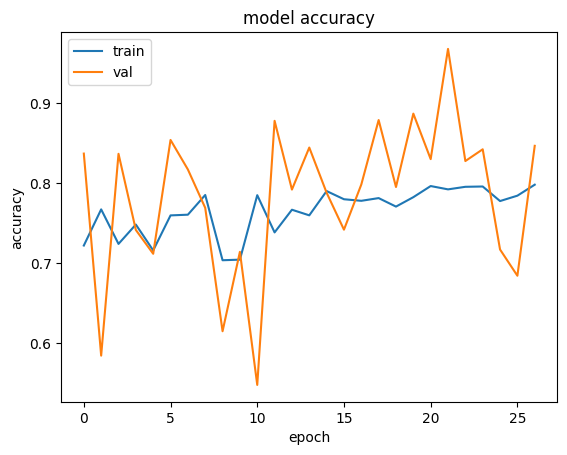

In [31]:
import keras
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [32]:
import pickle 
with open('models/ckpt/trainHistoryDict_3to30', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)
# with open('models/ckpt/trainHistoryDict', "rb") as file_pi:
#     history = pickle.load(file_pi)

In [33]:
fusion_model.save('models/VGG_POSE.keras')

In [1]:
from keras.models import load_model
fusion_model = load_model("models/VGG_POSE.keras")

In [38]:
from tabnanny import verbose
import cv2
import numpy as np
from video_processor import VideoProcessor
from ultralytics import YOLO

model = YOLO('models/yolov8m-pose.pt') 
vp = VideoProcessor(model, max_frames=100, img_sz=320, show_stream=False)

def predict_from_camera(model, resize=320, frame_buffer_size=10, buffer_size=10):
    """
    Captures frames from the camera, processes them, and makes predictions using the provided model.
    
    Parameters:
    - model: The trained model used for prediction.
    - resize: The size to which frames will be resized.
    - frame_buffer_size: The number of frames to buffer before processing.
    """
    cap = cv2.VideoCapture("examples/videos/person01_boxing_d1_uncomp.avi") # 0 is the default camera
    frame_buffer = np.zeros((1, 320, 320, 3))
    keypoints_buffer = np.zeros((10,1,34))  

    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break

            # Resize the frame
            frame = cv2.resize(frame, (resize, resize))

            # Add the frame to the buffer
            if keypoints_buffer.shape[1] != buffer_size:
                keypoints_batch = vp.process_image(frame)

                keypoints_buffer = np.concatenate((keypoints_buffer, keypoints_batch), axis=1)
                frame_buffer = np.concatenate((frame_buffer, np.expand_dims(frame, 0)), axis=0)
                # print(keypoints_buffer.shape)
                
            else:
                # Process the video frames (assuming vp.process_video is defined elsewhere)
                keypoints_batch = vp.process_video(frame)
                if keypoints_buffer.shape[1] + keypoints_batch.shape[1] > buffer_size:
                    excess_size = keypoints_buffer.shape[1] + keypoints_batch.shape[1] - buffer_size
                    keypoints_buffer = keypoints_buffer[:, excess_size:, :]
               
                keypoints_buffer = np.concatenate((keypoints_buffer, keypoints_batch), axis=1)

                # frame_buffer = np.concatenate((frame_buffer, np.expand_dims(frame, 0)), axis=0)

                # Make predictions using the model
                print(keypoints_buffer.shape, frame_buffer.shape)
                print(model.input_shape)
                predictions = model.predict([keypoints_buffer, frame_buffer], verbose=False)

                for id, person in enumerate(vp.data[0]):
                    x1 = int(person['box']['x1'])
                    y1 = int(person['box']['y1'])
                    x2 = int(person['box']['x2'])
                    y2 = int(person['box']['y2'])

                    color = (0,0,255) if predictions[id][0] > 0.6 else (0,255,0)             
                    frame = cv2.rectangle(frame, (x1,y1), (x2,y2), color, 5)


                print(predictions)

            if cv2.waitKey(1)==27:
                break
            cv2.imshow("output", frame)

                # Clear the frame buffer for the next batch of frames


    finally:
        cap.release()
        cv2.destroyAllWindows()

# Example usage:
# Assuming `model` is your trained model
predict_from_camera(fusion_model, buffer_size = fusion_model.input_shape[0][1])


(10, 10, 34) (10, 320, 320, 3)
[(None, 10, 34), (None, 320, 320, 3)]
[[          0]
 [    0.56801]
 [    0.59527]
 [    0.58182]
 [    0.60042]
 [    0.60189]
 [    0.59774]
 [    0.47172]
 [    0.52519]
 [    0.56869]]
(10, 10, 34) (10, 320, 320, 3)
[(None, 10, 34), (None, 320, 320, 3)]
[[          0]
 [    0.56801]
 [    0.59527]
 [    0.58182]
 [    0.60042]
 [    0.60189]
 [    0.59774]
 [    0.47172]
 [    0.52519]
 [    0.56869]]
(10, 10, 34) (10, 320, 320, 3)
[(None, 10, 34), (None, 320, 320, 3)]
[[          0]
 [    0.56801]
 [    0.59527]
 [    0.58182]
 [    0.60042]
 [    0.60189]
 [    0.59774]
 [    0.47172]
 [    0.52519]
 [    0.56869]]
(10, 10, 34) (10, 320, 320, 3)
[(None, 10, 34), (None, 320, 320, 3)]
[[          0]
 [    0.56801]
 [    0.59527]
 [    0.58182]
 [    0.60042]
 [    0.60189]
 [    0.59774]
 [    0.47172]
 [    0.52519]
 [    0.56869]]
(10, 10, 34) (10, 320, 320, 3)
[(None, 10, 34), (None, 320, 320, 3)]
[[          0]
 [    0.56801]
 [    0.59527]
 [    

In [12]:
fusion_model.input_shape[0][1]

10